<h1 style="font-size:40px;"> MLlib: Machine Learning con Spark </h1>


&nbsp;   

![](img/AdvancedAnalytics.jpg)

&nbsp;   

Otro de los módulos importantes del proyecto Spark es la librería de Machine Learning que se conoce con el nombre de [MLlib](https://spark.apache.org/docs/latest/ml-guide.html). Además de la documentación oficial una buena referencia sobre Machine Learning con Spark es el libro: [Advanced Analytics with Spark
](http://shop.oreilly.com/product/0636920035091.do).


Se conoce como MLlib al módule de ML de Spark, aunque realmente son dós librerías:

* `spark.mllib`: Es la primera de las dos, está basada en RDD y ahora mismo no se desarrolla más sobre esta.
* `spark.ml`: Está basada en los DataFrames es más potente y es la que se sigue desarrollando y mejorando.


De mano de sus creadores MLlib tiene los siguientes propósitos:

**MLlib’s Mission**
>MLlib’s mission is to make practical
machine learning easy and scalable.    
* Capable of learning from large-scale datasets    
* Easy to build machine learning applications 

&nbsp;   

Ya conocemos el flujo habitual de una aplicación de ML, podemos verlo resumido en el siguiente gráfico:


&nbsp;   

![](img/data_flow.jpeg)


&nbsp;   

Vamos a ver cómo usamos Spark y MLlib para cada uno de estos pasos:

In [4]:
import os
import pandas as pd
import numpy as np

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import Row

import pyspark.sql.functions as F
import pyspark.sql.types as T
from pyspark.sql.window import Window

In [5]:
conf = (

    SparkConf()
    .setAppName(u"[ICAI] Introducción ML")
    .set("spark.executor.memory","4g")
    .set("spark.executor.cores","2")

)

In [6]:
spark = (

    SparkSession.builder
    .config(conf=conf)
    .enableHiveSupport()
    .getOrCreate()

)

## 1. Get Data

Para la parte de adquisición y procesamiento de los datos usaremos los DF de spark.

Para el primer ejemplo, vamos a usar un dataset de *reviews* de Amazon, está basado en los datos que Amazon publica [aquí](https://snap.stanford.edu/data/web-Amazon.html). Veamos qué formato tienen:

In [4]:
reviewsDF = spark.read.parquet('/datos/reviews_amazon.parquet').cache()

In [5]:
reviewsDF.limit(20).toPandas()

,rating,review
0,5.0,This had some assembling but overall it is a g...
1,5.0,We love these markers. They state right on the...
2,5.0,It is the perfect size for storage under a bed...
3,3.0,"The hardware works very well, and the fact tha..."
4,5.0,I have not had a good camera since my early 20...
5,4.0,I had to modify it to fit my machine. I though...
6,5.0,Well &#34;Joe&#34; made it home for the holida...
7,5.0,The lamp this bulb was installed in died a lon...
8,5.0,I've had these for a few weeks. I absolutely ...
9,5.0,"Very nice rich color - slightly reddish, sturd..."


In [6]:
reviewsDF.printSchema()

root
 |-- rating: double (nullable = true)
 |-- review: string (nullable = true)



Como podemos ver tenemos una columna `rating` con la puntuación que el usuario a dado en su reseña, además la columna `review` es el texto que ha escrito. Veamos cómo se distribuye el campo `rating`:

In [7]:
agregado = reviewsDF.groupBy('rating').count().orderBy('rating')

In [8]:
agregado.toPandas()

,rating,count
0,1.0,1881
1,2.0,1138
2,3.0,1696
3,4.0,3460
4,5.0,11784


O mejor con porcentajes:

In [9]:
(

    agregado
    .crossJoin(agregado.select(F.sum("count").alias("total")))
    .withColumn('pcte', F.round(F.col('count') / F.col('total'),2) )
    .drop('total')
    .orderBy('rating')

).toPandas()

,rating,count,pcte
0,1.0,1881,0.09
1,2.0,1138,0.06
2,3.0,1696,0.08
3,4.0,3460,0.17
4,5.0,11784,0.59


Casi el 60% de las reseñas tienen un 5, 

**¿Somos capaces de predecir qué valor va a tener la reseña según el texto que se escribe?**

Es claro que si el texto tienen algunas palabras hay más posibilidades de tener una buena o mala valoración:

In [10]:
agregado2 = reviewsDF.filter(""" lower(review) LIKE '%great%' """).groupBy('rating').count()

In [11]:
(

    agregado2
    .crossJoin(agregado2.select(F.sum("count").alias("total")))
    .withColumn('pcte', F.round(F.col('count') / F.col('total'),2) )
    .drop('total')
    .orderBy('rating')

).toPandas()

,rating,count,pcte
0,1.0,142,0.03
1,2.0,139,0.03
2,3.0,242,0.05
3,4.0,840,0.17
4,5.0,3580,0.72


Filtrando por las que contengan la palabra 'great', vemos como el porcentaje de 5 sube hasta el 72%, ¿Qué pasara si la review contienen la cadena 'poor'?

In [12]:
agregado3 = reviewsDF.filter(""" lower(review) LIKE '%poor%' """).groupBy('rating').count()

In [13]:
(

    agregado3
    .crossJoin(agregado3.select(F.sum("count").alias("total")))
    .withColumn('pcte', F.round(F.col('count') / F.col('total'),2) )
    .drop('total')
    .orderBy('rating')

).toPandas()

,rating,count,pcte
0,1.0,81,0.34
1,2.0,55,0.23
2,3.0,28,0.12
3,4.0,24,0.10
4,5.0,47,0.20


Como era de esperar la distribución cambia y hay más peso en los valores bajos.

##  2. Clean, Prepare & Manipulate Data

Esta parte es una de la más laboriosas (y menos divertidas/gratificantes) de un proceso de ML. Además de poder usar los DF para hacer la parte más básica (seleccionar, filtrar, agrupar, unir...) con MLlib existen funciones que nos serán de gran ayuda en este apartado.

Se conocen bajo el nombre de [ml-features](https://spark.apache.org/docs/latest/ml-features.html) y tenemos a nuestra disposición todas estas funciones:

<ul id="markdown-toc">
  <li><a href="#feature-extractors" id="markdown-toc-feature-extractors">Feature Extractors</a>    <ul>
      <li><a href="#tf-idf" id="markdown-toc-tf-idf">TF-IDF</a></li>
      <li><a href="#word2vec" id="markdown-toc-word2vec">Word2Vec</a></li>
      <li><a href="#countvectorizer" id="markdown-toc-countvectorizer">CountVectorizer</a></li>
      <li><a href="#featurehasher" id="markdown-toc-featurehasher">FeatureHasher</a></li>
    </ul>
  </li>
  <li><a href="#feature-transformers" id="markdown-toc-feature-transformers">Feature Transformers</a>    <ul>
      <li><a href="#tokenizer" id="markdown-toc-tokenizer">Tokenizer</a></li>
      <li><a href="#stopwordsremover" id="markdown-toc-stopwordsremover">StopWordsRemover</a></li>
      <li><a href="#binarizer" id="markdown-toc-binarizer">Binarizer</a></li>
      <li><a href="#pca" id="markdown-toc-pca">PCA</a></li>
      <li><a href="#polynomialexpansion" id="markdown-toc-polynomialexpansion">PolynomialExpansion</a></li>
      <li><a href="#discrete-cosine-transform-dct" id="markdown-toc-discrete-cosine-transform-dct">Discrete Cosine Transform (DCT)</a></li>
      <li><a href="#stringindexer" id="markdown-toc-stringindexer">StringIndexer</a></li>
      <li><a href="#indextostring" id="markdown-toc-indextostring">IndexToString</a></li>
      <li><a href="#onehotencoder-deprecated-since-230" id="markdown-toc-onehotencoder-deprecated-since-230">OneHotEncoder (Deprecated since 2.3.0)</a></li>
      <li><a href="#onehotencoderestimator" id="markdown-toc-onehotencoderestimator">OneHotEncoderEstimator</a></li>
      <li><a href="#vectorindexer" id="markdown-toc-vectorindexer">VectorIndexer</a></li>
      <li><a href="#interaction" id="markdown-toc-interaction">Interaction</a></li>
      <li><a href="#normalizer" id="markdown-toc-normalizer">Normalizer</a></li>
      <li><a href="#standardscaler" id="markdown-toc-standardscaler">StandardScaler</a></li>
      <li><a href="#minmaxscaler" id="markdown-toc-minmaxscaler">MinMaxScaler</a></li>
      <li><a href="#maxabsscaler" id="markdown-toc-maxabsscaler">MaxAbsScaler</a></li>
      <li><a href="#bucketizer" id="markdown-toc-bucketizer">Bucketizer</a></li>
      <li><a href="#elementwiseproduct" id="markdown-toc-elementwiseproduct">ElementwiseProduct</a></li>
      <li><a href="#sqltransformer" id="markdown-toc-sqltransformer">SQLTransformer</a></li>
      <li><a href="#vectorassembler" id="markdown-toc-vectorassembler">VectorAssembler</a></li>
      <li><a href="#vectorsizehint" id="markdown-toc-vectorsizehint">VectorSizeHint</a></li>
      <li><a href="#quantilediscretizer" id="markdown-toc-quantilediscretizer">QuantileDiscretizer</a></li>
      <li><a href="#imputer" id="markdown-toc-imputer">Imputer</a></li>
    </ul>
  </li>
  <li><a href="#feature-selectors" id="markdown-toc-feature-selectors">Feature Selectors</a>    <ul>
      <li><a href="#vectorslicer" id="markdown-toc-vectorslicer">VectorSlicer</a></li>
      <li><a href="#rformula" id="markdown-toc-rformula">RFormula</a></li>
      <li><a href="#chisqselector" id="markdown-toc-chisqselector">ChiSqSelector</a></li>
    </ul>
  </li>
  <li><a href="#locality-sensitive-hashing" id="markdown-toc-locality-sensitive-hashing">Locality Sensitive Hashing</a>    <ul>
      <li><a href="#lsh-operations" id="markdown-toc-lsh-operations">LSH Operations</a>        <ul>
          <li><a href="#feature-transformation" id="markdown-toc-feature-transformation">Feature Transformation</a></li>
          <li><a href="#approximate-similarity-join" id="markdown-toc-approximate-similarity-join">Approximate Similarity Join</a></li>
          <li><a href="#approximate-nearest-neighbor-search" id="markdown-toc-approximate-nearest-neighbor-search">Approximate Nearest Neighbor Search</a></li>
        </ul>
      </li>
      <li><a href="#lsh-algorithms" id="markdown-toc-lsh-algorithms">LSH Algorithms</a>        <ul>
          <li><a href="#bucketed-random-projection-for-euclidean-distance" id="markdown-toc-bucketed-random-projection-for-euclidean-distance">Bucketed Random Projection for Euclidean Distance</a></li>
          <li><a href="#minhash-for-jaccard-distance" id="markdown-toc-minhash-for-jaccard-distance">MinHash for Jaccard Distance</a></li>
        </ul>
      </li>
    </ul>
  </li>
</ul>

Vamos a ver algunas de ellas usando nuestro ejemplo:

### RegexTokenizer

Con `RegexTokenizer` podemos dividir un texto por una expresión regular:

In [14]:
from pyspark.ml.feature import RegexTokenizer

#definimos el tokenizador que es un TRANSFORMADOR
tokenizer = (

    RegexTokenizer()
    .setInputCol("review") #columna de la que voy a leer
    .setOutputCol("tokens") #como voy a exportar la columna
    .setPattern("\\W+") #patron: separara por cualquier caracter no alfanumerico y contiguo (se los cargara y creara una list)

)

La librería `pyspark.ml` está inspirada en el proyecto [scikit-learn](http://scikit-learn.org/) de python, al igual que esta, para cada proceso/transformación que queramos realizar creamos primero un obejeto:

In [15]:
type(tokenizer)

pyspark.ml.feature.RegexTokenizer

En este caso el objeto es de tipo `RegexTokenizer`, una vez definido tendremos que usar `fit` si es necesario (en este caso no) y después `transform` para transformar nuestros datos.

In [16]:
tokenizedDF = tokenizer.transform(reviewsDF)

In [17]:
tokenizedDF.printSchema()

root
 |-- rating: double (nullable = true)
 |-- review: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [18]:
tokenizedDF.limit(5).toPandas()

,rating,review,tokens
0,5.0,This had some assembling but overall it is a g...,"[this, had, some, assembling, but, overall, it..."
1,5.0,We love these markers. They state right on the...,"[we, love, these, markers, they, state, right,..."
2,5.0,It is the perfect size for storage under a bed...,"[it, is, the, perfect, size, for, storage, und..."
3,3.0,"The hardware works very well, and the fact tha...","[the, hardware, works, very, well, and, the, f..."
4,5.0,I have not had a good camera since my early 20...,"[i, have, not, had, a, good, camera, since, my..."


In [19]:
tokenizedDF.first()['tokens'][:20]

['this',
 'had',
 'some',
 'assembling',
 'but',
 'overall',
 'it',
 'is',
 'a',
 'great',
 'product',
 'i',
 'am',
 'a',
 'youtuber',
 'and',
 'when',
 'i',
 'make',
 'car']

### Stop Words

Cuando trabajamos con texto y hacemos [*Text mining*](https://en.wikipedia.org/wiki/Text_mining), hay muchas palabras que se repiten mucho y no aportan significado, son por ejemplo los artículos, conjunciones...

Con `StopWordsRemover` podemos borrar estas palabras, la función de Spark está diseñada para el idioa en inglés (como el ejemplo), pero podemos encontrar diccionarios con las palabras comunes para el español y otros idiomas.

Por ejemplo: https://github.com/postgres/postgres/blob/master/src/backend/snowball/stopwords/spanish.stop

In [20]:
from pyspark.ml.feature import StopWordsRemover

remover = (

    StopWordsRemover()
    .setInputCol("tokens")
    .setOutputCol("stopWordFree")

)

In [21]:
type(remover)

pyspark.ml.feature.StopWordsRemover

In [22]:
removedStopWordsDF = remover.transform(tokenizedDF) #nos anadira una columna con las palabras menos las que ha eliminado

In [23]:
removedStopWordsDF.printSchema()

root
 |-- rating: double (nullable = true)
 |-- review: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stopWordFree: array (nullable = true)
 |    |-- element: string (containsNull = true)



In [24]:
removedStopWordsDF.limit(5).toPandas()

,rating,review,tokens,stopWordFree
0,5.0,This had some assembling but overall it is a g...,"[this, had, some, assembling, but, overall, it...","[assembling, overall, great, product, youtuber..."
1,5.0,We love these markers. They state right on the...,"[we, love, these, markers, they, state, right,...","[love, markers, state, right, package, washabl..."
2,5.0,It is the perfect size for storage under a bed...,"[it, is, the, perfect, size, for, storage, und...","[perfect, size, storage, bed, sturdy, holds, w..."
3,3.0,"The hardware works very well, and the fact tha...","[the, hardware, works, very, well, and, the, f...","[hardware, works, well, fact, solid, state, hu..."
4,5.0,I have not had a good camera since my early 20...,"[i, have, not, had, a, good, camera, since, my...","[good, camera, since, early, 20, managed, lose..."


In [25]:
removedStopWordsDF.select(F.size('tokens'),F.size('stopWordFree')).show()

+------------+------------------+
|size(tokens)|size(stopWordFree)|
+------------+------------------+
|          69|                29|
|          93|                42|
|          45|                20|
|         140|                65|
|         335|               170|
|          39|                15|
|          25|                14|
|          72|                34|
|          22|                 9|
|          20|                14|
|          49|                26|
|          66|                36|
|          71|                36|
|          27|                15|
|          26|                12|
|         101|                50|
|          23|                 7|
|          25|                14|
|          77|                39|
|          72|                41|
+------------+------------------+
only showing top 20 rows



De este modo hemos podido simplificar los datos, podemos ver el set de palabras usado del siguiente modo:

In [26]:
np.array(remover.getStopWords())

array(['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you',
       'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his',
       'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself',
       'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
       'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
       'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had',
       'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and',
       'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at',
       'by', 'for', 'with', 'about', 'against', 'between', 'into',
       'through', 'during', 'before', 'after', 'above', 'below', 'to',
       'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under',
       'again', 'further', 'then', 'once', 'here', 'there', 'when',
       'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
       'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 

### Count Vectorizer

Let's build a vocabulary of 1000 words from our reviews by building a [CountVectorizer](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.feature.CountVectorizer) model. We retain only the most frequent 1000 tokens that occur in the reviews.

Cuenta para las 1000 palabras mas frecuentes en los reviews el numero de veces que aparecen en cada review

In [27]:
from pyspark.ml.feature import CountVectorizer

counts = (
    
    CountVectorizer()
    .setInputCol("stopWordFree")
    .setOutputCol("features")
    .setVocabSize(1000) #voy a contar las 1000 palabras que mas aparezcan

)

In [28]:
type(counts)

pyspark.ml.feature.CountVectorizer

In [29]:
try:
    counts.transform(removedStopWordsDF)

except Exception as inst:
    print(inst)

'CountVectorizer' object has no attribute 'transform'


En este caso antes de usasr `transform`, tenemos que hacer `fit`. Esto es porque la función que queremos emplear necesita primero analizar los datos y "aprender" para luego poder transformarlo. 

**Nota:** Hacer `fit` se considera una acción para spark ya que tiene que evaluar así que suele ser un buen momento para cachear.

In [30]:
removedStopWordsDF.cache()
removedStopWordsDF.count()

19959

In [31]:
countModel = counts.fit(removedStopWordsDF) #aprende del data frame para ver cuales son las 1000 palabras mas usadas

In [32]:
type(countModel)

pyspark.ml.feature.CountVectorizerModel

In [33]:
np.array(countModel.vocabulary)[:100]

array(['one', 'great', 'like', 'good', 'use', 'product', 'well', 'get',
       'time', 'really', 'love', 'little', 'much', 'bought', 'also',
       'easy', 'price', 'works', 'used', 'work', 'even', '2', 'm', 've',
       'quality', 'buy', 'first', 'better', 'using', 'back', 'got',
       'made', 'recommend', '34', 'still', 'nice', 'two', 'make', 'case',
       '3', 'new', 'need', 'put', 'old', 'way', 'best', 'go', 'small',
       '5', 'phone', 'fit', 'day', 'long', 'set', 'perfect', '1', 'didn',
       'years', 'think', 'see', 'doesn', 'enough', 'want', 'right',
       'thing', 'find', 'another', 'around', 'light', 'since', 'amazon',
       '4', 'never', 'water', 'many', 'bit', 'without', 'every', 'take',
       'sure', 'lot', 'looking', 'know', 'year', 'hair', 'say', 'look',
       'size', 'purchased', 'keep', 'far', 'found', 'box', 'makes',
       'pretty', 'last', 're', 'came', 'money', 'hard'], dtype='<U13')

In [34]:
meta = countModel.transform(removedStopWordsDF)

In [35]:
meta.printSchema()

root
 |-- rating: double (nullable = true)
 |-- review: string (nullable = true)
 |-- tokens: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- stopWordFree: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- features: vector (nullable = true)



In [36]:
meta.limit(10).toPandas()

,rating,review,tokens,stopWordFree,features
0,5.0,This had some assembling but overall it is a g...,"[this, had, some, assembling, but, overall, it...","[assembling, overall, great, product, youtuber...","(0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
1,5.0,We love these markers. They state right on the...,"[we, love, these, markers, they, state, right,...","[love, markers, state, right, package, washabl...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,5.0,It is the perfect size for storage under a bed...,"[it, is, the, perfect, size, for, storage, und...","[perfect, size, storage, bed, sturdy, holds, w...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
3,3.0,"The hardware works very well, and the fact tha...","[the, hardware, works, very, well, and, the, f...","[hardware, works, well, fact, solid, state, hu...","(0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, ..."
4,5.0,I have not had a good camera since my early 20...,"[i, have, not, had, a, good, camera, since, my...","[good, camera, since, early, 20, managed, lose...","(0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,4.0,I had to modify it to fit my machine. I though...,"[i, had, to, modify, it, to, fit, my, machine,...","[modify, fit, machine, thought, model, right, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
6,5.0,Well &#34;Joe&#34; made it home for the holida...,"[well, 34, joe, 34, made, it, home, for, the, ...","[well, 34, joe, 34, made, home, holidays, exac...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
7,5.0,The lamp this bulb was installed in died a lon...,"[the, lamp, this, bulb, was, installed, in, di...","[lamp, bulb, installed, died, long, time, ago,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ..."
8,5.0,I've had these for a few weeks. I absolutely ...,"[i, ve, had, these, for, a, few, weeks, i, abs...","[ve, weeks, absolutely, love, ve, great, resul...","(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ..."
9,5.0,"Very nice rich color - slightly reddish, sturd...","[very, nice, rich, color, slightly, reddish, s...","[nice, rich, color, slightly, reddish, sturdy,...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."


In [37]:
meta.show() #fijate que guarda en features solo los que no son 0

+------+--------------------+--------------------+--------------------+--------------------+
|rating|              review|              tokens|        stopWordFree|            features|
+------+--------------------+--------------------+--------------------+--------------------+
|   5.0|This had some ass...|[this, had, some,...|[assembling, over...|(1000,[1,3,5,14,3...|
|   5.0|We love these mar...|[we, love, these,...|[love, markers, s...|(1000,[4,10,11,43...|
|   5.0|It is the perfect...|[it, is, the, per...|[perfect, size, s...|(1000,[6,9,54,61,...|
|   3.0|The hardware work...|[the, hardware, w...|[hardware, works,...|(1000,[1,4,5,6,7,...|
|   5.0|I have not had a ...|[i, have, not, ha...|[good, camera, si...|(1000,[1,2,3,14,2...|
|   4.0|I had to modify i...|[i, had, to, modi...|[modify, fit, mac...|(1000,[5,32,50,63...|
|   5.0|Well &#34;Joe&#34...|[well, 34, joe, 3...|[well, 34, joe, 3...|(1000,[6,31,33,10...|
|   5.0|The lamp this bul...|[the, lamp, this,...|[lamp, bulb, inst...

In [38]:
vector = meta.first()['features']

In [39]:
vector #lo guarda un poco raro: NO GUATDA LOS 0s
#las primeras palabras que eran las mas utilizadas en los reviews son logicamente las que mas se repiten

SparseVector(1000, {1: 1.0, 3: 2.0, 5: 1.0, 14: 1.0, 37: 1.0, 42: 1.0, 46: 1.0, 65: 1.0, 99: 1.0, 163: 1.0, 181: 1.0, 184: 1.0, 197: 2.0, 216: 1.0, 297: 1.0, 518: 2.0})

In [40]:
type(vector)

pyspark.ml.linalg.SparseVector

Es un vector de Spark de tipo *sparse*

In [41]:
vector.toArray()[:50] #podiamos pasarlo a array

array([0., 1., 0., 2., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0.])

In [42]:
vector.values #podriamos coger solo los valores

array([1., 2., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 2., 1., 1., 2.])

In [43]:
vector.indices #o solo los indices

array([  1,   3,   5,  14,  37,  42,  46,  65,  99, 163, 181, 184, 197,
       216, 297, 518], dtype=int32)

In [44]:
import scipy.sparse as sp

In [45]:
#COMO SERIA ESTO EN PYTHON?

matrix_sparse = sp.csr_matrix(

    (vector.values,(np.zeros_like(vector.values),vector.indices)),
    shape=(1,vector.size)

)

In [46]:
matrix_sparse

<1x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 16 stored elements in Compressed Sparse Row format>

In [47]:
print(matrix_sparse)

  (0, 1)	1.0
  (0, 3)	2.0
  (0, 5)	1.0
  (0, 14)	1.0
  (0, 37)	1.0
  (0, 42)	1.0
  (0, 46)	1.0
  (0, 65)	1.0
  (0, 99)	1.0
  (0, 163)	1.0
  (0, 181)	1.0
  (0, 184)	1.0
  (0, 197)	2.0
  (0, 216)	1.0
  (0, 297)	1.0
  (0, 518)	2.0


### Binarizer

En este ejemplo queremos seperar las reseñan en "positivas" o "negativas". Así que en este caso queremos convertir la variable `rating` en dos grupos.

En Spark tenemos dos funciones que nos pueden ayudar a esto:

* `Bucketizer` que es más general y sirve para dividir una variable numérica en un número de grupos,es similar a la función `findInterval` de R o a `bisect` de python.

* `Binarizer` que como su propio nombre indica sirve para convertir en dos clases.

In [48]:
from pyspark.ml.feature import Binarizer

binarizer = (

    Binarizer()
    .setInputCol("rating") #elegimos la columna rating
    .setOutputCol("label") #la vamos a llamar label a la nueva colummna de 1s y 0s
    .setThreshold(3.5) #cortamos en 3.5

)

In [49]:
meta = binarizer.transform(meta)

In [50]:
meta.limit(10).toPandas()

,rating,review,tokens,stopWordFree,features,label
0,5.0,This had some assembling but overall it is a g...,"[this, had, some, assembling, but, overall, it...","[assembling, overall, great, product, youtuber...","(0.0, 1.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0
1,5.0,We love these markers. They state right on the...,"[we, love, these, markers, they, state, right,...","[love, markers, state, right, package, washabl...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
2,5.0,It is the perfect size for storage under a bed...,"[it, is, the, perfect, size, for, storage, und...","[perfect, size, storage, bed, sturdy, holds, w...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1.0
3,3.0,"The hardware works very well, and the fact tha...","[the, hardware, works, very, well, and, the, f...","[hardware, works, well, fact, solid, state, hu...","(0.0, 2.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 4.0, ...",0.0
4,5.0,I have not had a good camera since my early 20...,"[i, have, not, had, a, good, camera, since, my...","[good, camera, since, early, 20, managed, lose...","(0.0, 1.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1.0
5,4.0,I had to modify it to fit my machine. I though...,"[i, had, to, modify, it, to, fit, my, machine,...","[modify, fit, machine, thought, model, right, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0
6,5.0,Well &#34;Joe&#34; made it home for the holida...,"[well, 34, joe, 34, made, it, home, for, the, ...","[well, 34, joe, 34, made, home, holidays, exac...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...",1.0
7,5.0,The lamp this bulb was installed in died a lon...,"[the, lamp, this, bulb, was, installed, in, di...","[lamp, bulb, installed, died, long, time, ago,...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",1.0
8,5.0,I've had these for a few weeks. I absolutely ...,"[i, ve, had, these, for, a, few, weeks, i, abs...","[ve, weeks, absolutely, love, ve, great, resul...","(0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",1.0
9,5.0,"Very nice rich color - slightly reddish, sturd...","[very, nice, rich, color, slightly, reddish, s...","[nice, rich, color, slightly, reddish, sturdy,...","(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...",1.0


Con estos pasos, ya hemos conseguido tener una columna `features` que será nuestra matriz $X$ de aprendizaje y una columna `label` que es de la que queremos aprender con un modelo de clasificación binaria.

## 3. Train Model

Esta es la parte donde usaremos modelos de Machine Learning propiamente dicho, con Spark podemos hacer bastantes cosas, desde [modelos supervisados](https://spark.apache.org/docs/latest/ml-classification-regression.html), [clustering](https://spark.apache.org/docs/latest/ml-clustering.html), [sistemas de recomendaciones](https://spark.apache.org/docs/latest/ml-collaborative-filtering.html) y [reglas se asociación](https://spark.apache.org/docs/latest/ml-frequent-pattern-mining.html).


&nbsp;  
&nbsp;  

Volviento a nuesto ejemplo, es claro que es un problema supervisado de clasificación (sentimiento positivo o negativo) veamos qué tipo de modelos de clasifación tenemos en Spark:

<ul id="markdown-toc">
  <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#classification" id="markdown-toc-classification">Classification</a>    <ul>
      <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#logistic-regression" id="markdown-toc-logistic-regression">Logistic regression</a>        <ul>
          <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#binomial-logistic-regression" id="markdown-toc-binomial-logistic-regression">Binomial logistic regression</a></li>
          <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#multinomial-logistic-regression" id="markdown-toc-multinomial-logistic-regression">Multinomial logistic regression</a></li>
        </ul>
      </li>
      <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#decision-tree-classifier" id="markdown-toc-decision-tree-classifier">Decision tree classifier</a></li>
      <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#random-forest-classifier" id="markdown-toc-random-forest-classifier">Random forest classifier</a></li>
      <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#gradient-boosted-tree-classifier" id="markdown-toc-gradient-boosted-tree-classifier">Gradient-boosted tree classifier</a></li>
      <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier" id="markdown-toc-multilayer-perceptron-classifier">Multilayer perceptron classifier</a></li>
      <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#linear-support-vector-machine" id="markdown-toc-linear-support-vector-machine">Linear Support Vector Machine</a></li>
      <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#one-vs-rest-classifier-aka-one-vs-all" id="markdown-toc-one-vs-rest-classifier-aka-one-vs-all">One-vs-Rest classifier (a.k.a. One-vs-All)</a></li>
      <li><a href="https://spark.apache.org/docs/latest/ml-classification-regression.html#naive-bayes" id="markdown-toc-naive-bayes">Naive Bayes</a></li>
    </ul>
  </li>
  
</ul>

In [51]:
from pyspark.ml.classification import LogisticRegression

print(LogisticRegression().explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The bounds vector size must beequal wi

In [52]:
rl = LogisticRegression(featuresCol='features', #variable de emtrada
                        labelCol = 'label', #variable de salida
                        predictionCol='labelCol' #esta colunma sera la de la prediccion)

In [53]:
modelo = rl.fit(meta) #si que tiene que hacer fit porque tiene que aprender de los modelos

In [54]:
modelo.coefficients[:40]

array([ 0.05539396,  1.0620651 ,  0.05371914,  0.21893744,  0.06806565,
       -0.25884074,  0.55660344, -0.19275559, -0.02909625, -0.09761498,
        1.40608576,  0.25216638, -0.00571913, -0.04102093,  0.0499756 ,
        0.83604661,  0.31962407,  0.48671637,  0.18476393, -0.50561418,
       -0.2869175 , -0.0235039 ,  0.0129517 ,  0.29153212,  0.08648835,
       -0.1861831 ,  0.08382417, -0.10093676,  0.23850552, -0.41111558,
       -0.03836653, -0.26403495,  0.06089811, -0.02265092,  0.159968  ,
        0.48816559, -0.30278214,  0.04610715,  0.07930039, -0.25221191])

In [55]:
predicciones = modelo.transform(meta.select('label','features'))

In [56]:
predicciones.printSchema()

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- labelCol: double (nullable = false)



In [57]:
predicciones.show() #el raw no se usa casi nunca, la prob si (debe haber un e^) 

+-----+--------------------+--------------------+--------------------+--------+
|label|            features|       rawPrediction|         probability|labelCol|
+-----+--------------------+--------------------+--------------------+--------+
|  1.0|(1000,[1,3,5,14,3...|[-4.4977676628692...|[0.01101122621757...|     1.0|
|  1.0|(1000,[4,10,11,43...|[-6.2386230214074...|[0.00194873728958...|     1.0|
|  1.0|(1000,[6,9,54,61,...|[-5.4360796186942...|[0.00433763207075...|     1.0|
|  0.0|(1000,[1,4,5,6,7,...|[-3.1958712221916...|[0.03932139197717...|     1.0|
|  1.0|(1000,[1,2,3,14,2...|[-12.537692114717...|[3.58878912475756...|     1.0|
|  1.0|(1000,[5,32,50,63...|[-0.1369912419279...|[0.46580564877646...|     1.0|
|  1.0|(1000,[6,31,33,10...|[-2.5310866697984...|[0.07370742023978...|     1.0|
|  1.0|(1000,[6,8,9,15,3...|[-4.0661836642483...|[0.01685376723437...|     1.0|
|  1.0|(1000,[1,4,8,10,2...|[-3.4552046131211...|[0.03061402515385...|     1.0|
|  1.0|(1000,[5,15,35,42...|[-4.58838267

In [58]:
fila = predicciones.first()

In [59]:
fila['rawPrediction']

DenseVector([-4.4978, 4.4978])

In [60]:
fila['probability']

DenseVector([0.011, 0.989])

In [61]:
fila['labelCol']

1.0

En muchas ocasiones no está claro qué modelo es el más adecuado, existen algunos "chuletas" como la de abajo, pero lo mejor es conocer bien la teoría de los modelos a emplear para no cometer errores de concepto y usar metodologías apropiadas para asegurarse que el modelo está funcionando correctamente.

![](img/ml_map.png)

###  4. Test data

Uno de los procedimientos más importantes a la hora de hacer un ML es comprobar si nuestro modelo funciona correctamente para otros datos con los que no hemos entrenado el modelo, así evitaremos el problema de [sobreajuste o *overfitting*]https://en.wikipedia.org/wiki/Overfitting.

Vamos a usar la función [RandomSplit](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) para dividir nuestro DF en dos partes así usaremos una para entrenar y otroa para evaluar el modelo.

![trainTest](img/TrainTestSplit.png)

Vamos a dividir el DF original en dos partes, volvemos a trabajar con el DF original ya que las transformaciones y extraer las *features* también son partes del modelo y si lo hacemos con todo el DF podemos estar siendo imparciales.

In [62]:
(trainDF, testDF) = reviewsDF.randomSplit([0.8, 0.2], seed=42)
trainDF.cache()
testDF.cache()

DataFrame[rating: double, review: string]

In [63]:
n = reviewsDF.count()
print("Total de registros en el DF original: {}".format(n))
print("Porcentaje en  train respecto al original: {}".format(1.0 * trainDF.count() / n))
print("Porcentaje en  test respecto al original: {}".format(1.0 * testDF.count() / n))

Total de registros en el DF original: 19959
Porcentaje en  train respecto al original: 0.8023448068540509
Porcentaje en  test respecto al original: 0.1976551931459492


Ahora debemos de hacer el procesamiento que hemos visto para el dataset de entrenamiento y guradarlo para después realizarlo en el de test o validación y en un futuro en un nuevo dataset que queramos predecir. 

#### 4.1 Pipelines

Como esta tarea puede ser un un poco tediosa Spark ha introducido el concepto de [**Pipeline**](https://spark.apache.org/docs/latest/ml-pipeline.html) (también basado en el de [scikit-learn](http://scikit-learn.org/stable/modules/pipeline.html)):

In [64]:
from pyspark.ml import Pipeline

In [65]:
tokenizer = (

    RegexTokenizer()
    .setInputCol("review")
    .setOutputCol("tokens")
    .setPattern("\\W+")

)

remover = (

    StopWordsRemover()
    .setInputCol("tokens")
    .setOutputCol("stopWordFree")

)

counts = (
    
    CountVectorizer()
    .setInputCol("stopWordFree")
    .setOutputCol("features")
    .setVocabSize(1000)

)

binarizer = (

    Binarizer()
    .setInputCol("rating")
    .setOutputCol("label")
    .setThreshold(3.5)

)

rl = LogisticRegression(featuresCol='features',predictionCol='labelCol')

In [66]:
p = Pipeline(stages=[tokenizer, remover, counts, binarizer, rl])

In [67]:
p

Pipeline_46a0853a885f703674ca

In [68]:
type(p)

pyspark.ml.pipeline.Pipeline

Ahora defino/entreno todas las transformaciones a la vez (¡más eficiente!) para los datos de entrenamiento:

In [69]:
p_model = p.fit(trainDF)

In [70]:
p_model

PipelineModel_4cb2a561ec6480c1cd36

In [71]:
p_model.transform(trainDF).limit(4).toPandas()

,rating,review,tokens,stopWordFree,features,label,rawPrediction,probability,labelCol
0,1.0,"""This is gonna be fun"" it says on the box. Ok...","[this, is, gonna, be, fun, it, says, on, the, ...","[gonna, fun, says, box, okay, goes, people, wo...","(1.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, ...",0.0,"[2.7372801707214243, -2.7372801707214243]","[0.93919094909386, 0.06080905090614005]",0.0
1,1.0,2 out of 3 fell apart when played with by my p...,"[2, out, of, 3, fell, apart, when, played, wit...","[2, 3, fell, apart, played, puppy, one, create...","(1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[1.3529490111555629, -1.3529490111555629]","[0.7946113372529741, 0.20538866274702589]",0.0
2,1.0,"3 months, all does not work, do not give refun...","[3, months, all, does, not, work, do, not, giv...","[3, months, work, give, refunds, hateful, 34, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[-0.6048582604573204, 0.6048582604573204]","[0.3532329885055081, 0.6467670114944919]",1.0
3,1.0,50 cent is the most garbage rapper ever period...,"[50, cent, is, the, most, garbage, rapper, eve...","[50, cent, garbage, rapper, ever, period, poet...","(1.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[-0.44672777499593347, 0.44672777499593347]","[0.3901390479363134, 0.6098609520636867]",1.0


Puedo ahora hacer la misma tranformación o "predecir" sobre el otro dataset:

In [72]:
result = p_model.transform(testDF)
result.limit(4).toPandas()

,rating,review,tokens,stopWordFree,features,label,rawPrediction,probability,labelCol
0,1.0,... which should have been the principal desig...,"[which, should, have, been, the, principal, de...","[principal, design, goal, close, enough, appea...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",0.0,"[5.2669429507596135, -5.2669429507596135]","[0.9948671234490613, 0.005132876550938797]",0.0
1,1.0,...if you are looking for a way to get that St...,"[if, you, are, looking, for, a, way, to, get, ...","[looking, way, get, starbucks, pumpkin, spice,...","(0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...",0.0,"[0.25453802784203483, -0.25453802784203483]","[0.5632931472183439, 0.4367068527816561]",0.0
2,1.0,1. It won't connect wirelessly;2. It makes alm...,"[1, it, won, t, connect, wirelessly, 2, it, ma...","[1, won, connect, wirelessly, 2, makes, almost...","(0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, ...",0.0,"[2.202556320948331, -2.202556320948331]","[0.9004788345814635, 0.09952116541853658]",0.0
3,1.0,A wheel is broken. The pouch inside has compl...,"[a, wheel, is, broken, the, pouch, inside, has...","[wheel, broken, pouch, inside, completely, rip...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0.0,"[0.2959415564212704, -0.2959415564212704]","[0.5734500980781883, 0.4265499019218117]",0.0


Gracias a las *pipelines* nos es muy fácil reutilizar las transformaciones y modelos para nuevos DF, es hora de evaluar nuestro modelo con la muestra de test.

#### 4.2 Evaluación del modelo

Dentro de nuestro objeto de tipo `PipelineModel` tenemos toda la información de los subprocesos que hace, por ejemplo:

In [73]:
p_model.stages

[RegexTokenizer_41a2a63d0d56a3b63867,
 StopWordsRemover_421f94af7b1e8ff2543e,
 CountVectorizer_43cab63f5c67deb279c1,
 Binarizer_49c5be7c8fb01447d01a,
 LogisticRegression_484198cd1fbeb850d14f]

In [74]:
np.array(p_model.stages[2].vocabulary)[:100]

array(['one', 'great', 'like', 'good', 'use', 'product', 'well', 'get',
       'time', 'really', 'love', 'little', 'much', 'also', 'price',
       'bought', 'easy', 'works', 'used', 'work', 'even', '2', 'quality',
       've', 'm', 'buy', 'first', 'better', 'back', 'using', 'got', '34',
       'made', 'recommend', 'still', 'nice', 'two', 'make', 'case', '3',
       'put', 'need', 'new', 'way', 'old', 'go', 'best', 'phone', 'small',
       'fit', '5', 'day', 'long', '1', 'years', 'perfect', 'didn', 'set',
       'see', 'enough', 'doesn', 'think', 'right', 'thing', 'around',
       'another', 'since', 'want', 'find', 'light', 'never', '4',
       'amazon', 'bit', 'water', 'many', 'sure', 'lot', 'take', 'every',
       'without', 'know', 'year', 'say', 'look', 'last', 'hair',
       'purchased', 'far', 'looking', 'keep', 'size', 're', 'pretty',
       'came', 'found', 'money', 'however', 'makes', 'looks'],
      dtype='<U13')

Si hacemos al *stage* del modelo, podemos encontrar la curva ROC para evaluar cómo está funcionando el modelo:

In [75]:
auc = p_model.stages[-1].summary.areaUnderROC
auc

0.9090491693408799

In [76]:
df_roc = p_model.stages[-1].summary.roc.toPandas()

In [77]:
df_roc.head()

,FPR,TPR
0,0.000000,0.000000
1,0.000000,0.013151
2,0.000265,0.026140
3,0.000530,0.039128
4,0.000530,0.052197


In [78]:
import matplotlib.pyplot as plt
%matplotlib inline

<Figure size 432x288 with 0 Axes>

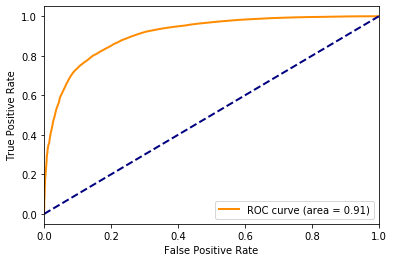

In [79]:
plt.figure()
df_roc.plot('FPR','TPR', color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

Pero como sabemos, es mejor evaluar el modelo sobre el dataset de test que hemos preparado, para ello podemos usar la función [`BinaryClassificationEvaluator`](https://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.BinaryClassificationEvaluator) para calcular la curva ROC.

In [80]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

evaluator = BinaryClassificationEvaluator()
print("AUC: {}".format(evaluator.evaluate(result))) #result era lo que daba el modelo en el conjunto de test

AUC: 0.8507633299256857


Cómo era de esperar baja un poco el valor del área bajo la curva.

In [7]:
spark.stop()